<h1>Task 1: Creating the Surrogate Model</h1>

In [316]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input,Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
import pandas as pd
import seaborn as sns

<font size=5>Loading the dataset and splitting it to 60% training and 40% validation</font>

In [317]:
dataset=pd.read_csv("./Desktop/ds_opt/dataset2.csv")

In [318]:
dataset['Res']=dataset['Width']*dataset['Height']
dataset

,Resolution,Width,Height,size(MB),time(Seconds),PPI,PPI(Normalized),Res
0,16x16,16,16,0.000768,0,4.351,0.000000,256
1,42x11,42,11,0.001386,0,8.350,0.001182,462
2,32x32,32,32,0.003072,0,8.703,0.001286,1024
3,40x30,40,30,0.003600,0,9.615,0.001555,1200
4,42x32,42,32,0.004032,0,10.154,0.001715,1344
...,...,...,...,...,...,...,...,...
188,7680x4800,7680,4800,110.600000,1264,1741.700,0.513303,36864000
189,8192x4608,8192,4608,113.250000,1294,1807.500,0.532743,37748736
190,10240x4320,10240,4320,132.700000,1516,2137.300,0.630183,44236800
191,8192x8192,8192,8192,201.330000,2300,2228.000,0.656981,67108864


In [319]:
train_data=dataset.sample(frac=0.6,random_state=0)
test_data=dataset.drop(train_data.index)

<font size=5>Sanity check that train and test set are unique</font>

In [320]:
print(test_data.merge(train_data).empty)

True


<font size=5>As we can see below, the time and quality are functions of Resolution</font>

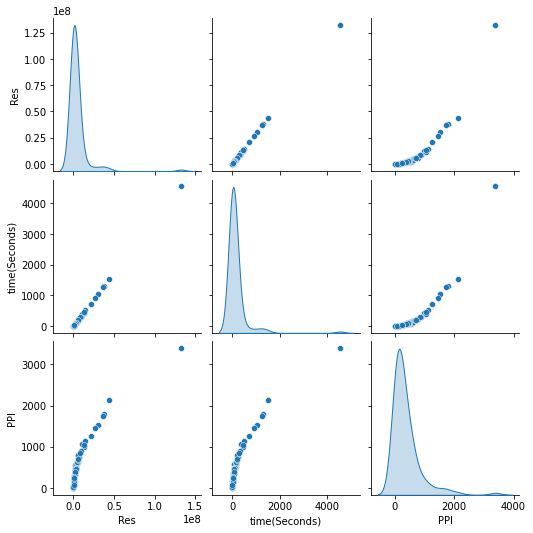

In [321]:
sns.pairplot(train_data[['Res','time(Seconds)','PPI']],diag_kind='kde')

<font size=5>Getting rid of useless features, because we are interested in the Width and Height only</font>

In [322]:
train_data.pop('PPI(Normalized)')
train_data.pop('size(MB)')
train_data.pop('Resolution')
train_data.pop('Res')
test_data.pop('PPI(Normalized)')
test_data.pop('size(MB)')
test_data.pop('Resolution')
test_data.pop('Res')

1           462
3          1200
6          2400
9          4608
11         4800
         ...   
177     9216000
182    16384000
184    20358144
187    33177600
191    67108864
Name: Res, Length: 77, dtype: int64

<font size=5>Separate features from labels in both Training and Test set</font>

In [323]:
train_features=train_data.copy()
test_features=test_data.copy()
train_labels1=train_features.pop('time(Seconds)').tolist()
train_labels2=train_features.pop('PPI').tolist()
test_labels1=test_features.pop('time(Seconds)').tolist()
test_labels2=test_features.pop('PPI').tolist()

train_labels=np.concatenate((np.array(train_labels1).reshape((len(train_features),1)),np.array(train_labels2).reshape(len(train_features),1)),axis=1)
test_labels=np.concatenate((np.array(test_labels1).reshape((len(test_features),1)),np.array(test_labels2).reshape(len(test_features),1)),axis=1)

<font size=5>Creating the model</font>

In [324]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
#Feature normalization layer that normalizes the training features

In [325]:
model=keras.Sequential([
    normalizer,
    Dense(256,activation='relu'),
    Dense(512,activation='relu'),
    Dense(2)
])
model.compile(optimizer='adam',loss='MeanAbsoluteError')
early_stop=EarlyStopping(monitor='val_loss',mode='min',patience=100,restore_best_weights=True)
early_stop2=EarlyStopping(monitor='loss',mode='min',patience=50,restore_best_weights=True)

<font size=5>Training the model using a callback function for early stopping to avoid overfitting, and using 20% of the training set as a cross-validation set</font>

In [326]:
hist_train=model.fit(train_features,train_labels,validation_split=0.2,epochs=2000,callbacks=[early_stop])

Epoch 1/2000
3/3 [==============================] - 0s 36ms/step - loss: 290.4792 - val_loss: 160.5719
Epoch 2/2000
3/3 [==============================] - 0s 6ms/step - loss: 290.1683 - val_loss: 160.3266
Epoch 3/2000
3/3 [==============================] - 0s 6ms/step - loss: 289.8883 - val_loss: 160.0237
Epoch 4/2000
3/3 [==============================] - 0s 6ms/step - loss: 289.4748 - val_loss: 159.6292
Epoch 5/2000
3/3 [==============================] - 0s 6ms/step - loss: 288.9715 - val_loss: 159.1304
Epoch 6/2000
3/3 [==============================] - 0s 6ms/step - loss: 288.3684 - val_loss: 158.5052
Epoch 7/2000
3/3 [==============================] - 0s 6ms/step - loss: 287.6122 - val_loss: 157.8536
Epoch 8/2000
3/3 [==============================] - 0s 6ms/step - loss: 286.5591 - val_loss: 157.0890
Epoch 9/2000
3/3 [==============================] - 0s 6ms/step - loss: 285.4123 - val_loss: 156.1876
Epoch 10/2000
3/3 [==============================] - 0s 6ms/step - loss: 284.1926

In [330]:
hist_acc=model.evaluate(test_features,test_labels)

3/3 [==============================] - 0s 997us/step - loss: 3.5949


<font size=5>The loss is acceptable, so we can now train the model on the test set so it can improve even more</font>

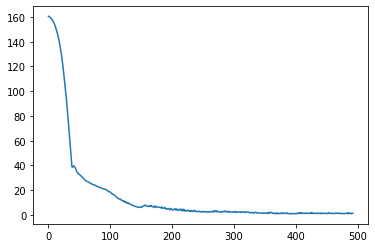

In [328]:
plt.plot(range(len(hist_train.history['val_loss'])),hist_train.history['val_loss'])

In [329]:
model.fit(test_features,test_labels,epochs=1000,callbacks=[early_stop],validation_split=0.2)

Epoch 1/1000
2/2 [==============================] - 0s 22ms/step - loss: 1.0776 - val_loss: 13.2150
Epoch 2/1000
2/2 [==============================] - 0s 8ms/step - loss: 1.0610 - val_loss: 13.2922
Epoch 3/1000
2/2 [==============================] - 0s 8ms/step - loss: 1.0664 - val_loss: 13.4574
Epoch 4/1000
2/2 [==============================] - 0s 8ms/step - loss: 1.0474 - val_loss: 13.5467
Epoch 5/1000
2/2 [==============================] - 0s 8ms/step - loss: 1.0623 - val_loss: 13.5510
Epoch 6/1000
2/2 [==============================] - 0s 7ms/step - loss: 1.0535 - val_loss: 13.6403
Epoch 7/1000
2/2 [==============================] - 0s 8ms/step - loss: 1.0681 - val_loss: 13.6380
Epoch 8/1000
2/2 [==============================] - 0s 8ms/step - loss: 1.0306 - val_loss: 13.7710
Epoch 9/1000
2/2 [==============================] - 0s 8ms/step - loss: 1.0446 - val_loss: 14.0974
Epoch 10/1000
2/2 [==============================] - 0s 7ms/step - loss: 1.0642 - val_loss: 14.0715
Epoch 11

<h1>Task 2: Finding the best trade-off (Multi-objective optimization)</h1>

In [355]:
#This cell was made using exhaustive brute force of the weight below on the PPI (Quality), and it was concluded that by
#increasing the weight of the PPI objective function, it changes the resolution, but between -500,000 and -1,500,000
#The minimum weighted sum remained the same, and though we achieved the best trade-off with no boundaries on either quality
#nor time.
#The method used is weighted sum that minimizes time and maximizes quality, so to make it simpler, the weighted sum was used to
#minimize time and minimize the inverse of quality.

list_time=[]
list_ppi=[]
list_res=[]
min_sum=10000000
min_i=0
min_j=0
k=0
for i,j in zip(dataset['Width'],dataset['Height']):
        arr=model.predict([[i,j]])
        ppi_now=-1./arr[0][1].squeeze()
        time_now=arr[0][0].squeeze()
        list_time.append(max(0,time_now))
        list_res.append((i,j))
        list_ppi.append(ppi_now)
        i_sum=(-1500000*ppi_now)+time_now
        if i_sum<min_sum:
            min_sum=i_sum
            min_i=i
            min_j=j


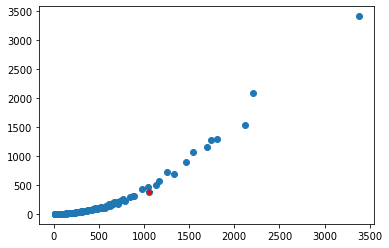

In [356]:
list_ppi=-1./np.array(list_ppi)
ind=list_res.index((min_i,min_j))
plt.scatter(list_ppi,list_time)
plt.plot(list_ppi[ind],list_time[ind],"r*")

##A scatter plot of time and quality and the red dot represents the best tradeoff

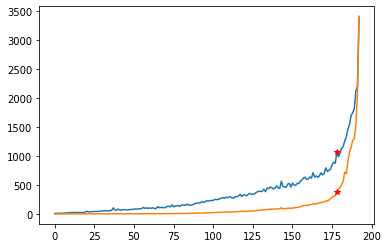

In [357]:
plt.plot(range(len(list_ppi)),list_ppi)
plt.plot(range(len(list_time)),list_time)
plt.plot(ind,list_time[ind],"r*")
plt.plot(ind,list_ppi[ind],"r*")
##A plot of time and quality and the red dots represents the best tradeoff time and quality

In [361]:
arr=model.predict([[5120,2160]])
time=arr[0][0].squeeze()
qua=arr[0][1].squeeze()
print("Best trade-off resolution is: "+str(min_i)+"x"+str(min_j)+" that takes time= "+str(time)+" seconds and quality= "+str(qua)+" PPI(Pixels per inch)")


Best trade-off resolution is: 5120x2160 that takes time= 381.56366 seconds and quality= 1058.0343 PPI(Pixels per inch)
